In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sys
sys.path.append('../src')
import config
from explain import get_decision_path, get_risk_level

# Load model and test data
model = joblib.load('../models/decision_tree_model.pkl')
test_df = pd.read_csv('../data/processed/test.csv')

X_test = test_df[config.FEATURE_COLUMNS]
y_test = test_df['defect']

print(f"Model loaded. Test set: {len(X_test)} samples")


Model loaded. Test set: 1211 samples


In [2]:
# Get predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Find errors
false_positives = (y_pred == 1) & (y_test == 0)  # Predicted defect, actually clean
false_negatives = (y_pred == 0) & (y_test == 1)  # Predicted clean, actually defect
true_positives = (y_pred == 1) & (y_test == 1)
true_negatives = (y_pred == 0) & (y_test == 0)

print("="*60)
print("ERROR ANALYSIS")
print("="*60)
print(f"False Positives (FP): {false_positives.sum()} ({false_positives.sum()/len(y_test)*100:.1f}%)")
print(f"False Negatives (FN): {false_negatives.sum()} ({false_negatives.sum()/len(y_test)*100:.1f}%)")
print(f"True Positives (TP): {true_positives.sum()} ({true_positives.sum()/len(y_test)*100:.1f}%)")
print(f"True Negatives (TN): {true_negatives.sum()} ({true_negatives.sum()/len(y_test)*100:.1f}%)")

print(f"Total Errors: {(false_positives.sum() + false_negatives.sum())} / {len(y_test)}")
print(f"Error Rate: {(false_positives.sum() + false_negatives.sum())/len(y_test)*100:.1f}%")


ERROR ANALYSIS
False Positives (FP): 159 (13.1%)
False Negatives (FN): 127 (10.5%)
True Positives (TP): 478 (39.5%)
True Negatives (TN): 447 (36.9%)
Total Errors: 286 / 1211
Error Rate: 23.6%


WORST FALSE POSITIVES (High confidence, but actually clean)
Total FP: 159

Top 5 most confident wrong predictions:
      predicted_prob  cbo  wmc  dit  rfc  lcom
854         0.909091   17   63    6  101    45
85          0.909091  204  560   21  518  1084
298         0.909091    0    0    1    0     0
686         0.909091   75  115   17  154   783
1063        0.909091   13  114    2   98    78
False positive analysis saved


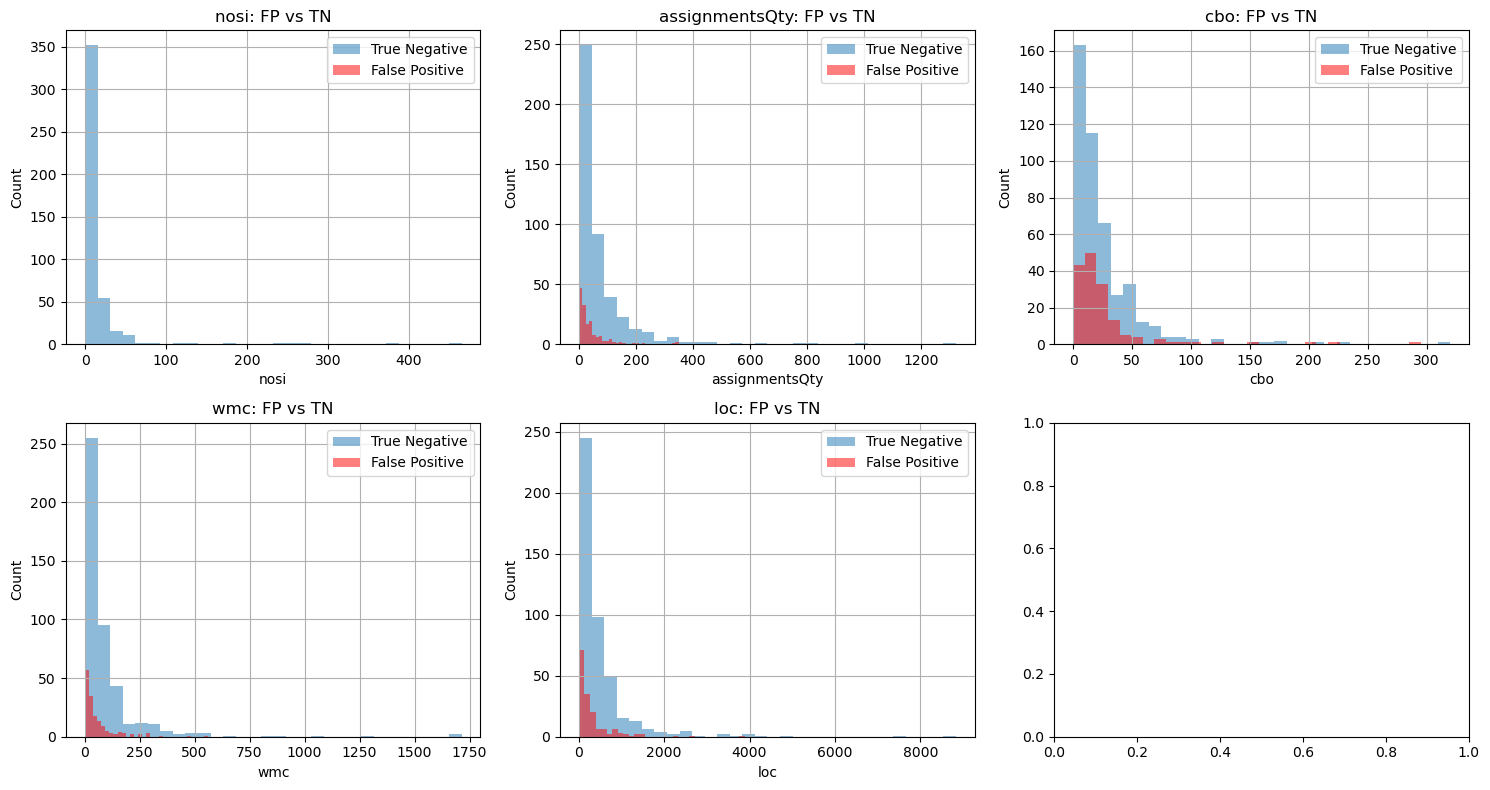

In [3]:
# Get worst false positives (high confidence but wrong)
fp_data = X_test[false_positives].copy()
fp_data['true_label'] = y_test[false_positives]
fp_data['predicted_prob'] = y_proba[false_positives]
fp_data = fp_data.sort_values('predicted_prob', ascending=False)

print("="*60)
print("WORST FALSE POSITIVES (High confidence, but actually clean)")
print("="*60)
print(f"Total FP: {len(fp_data)}")
print(f"\nTop 5 most confident wrong predictions:")
print(fp_data[['predicted_prob'] + config.FEATURE_COLUMNS[:5]].head())

# Visualize feature distributions
top_5_features = ['nosi', 'assignmentsQty', 'cbo', 'wmc', 'loc']  # Top important features
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for i, feat in enumerate(top_5_features):
    ax = axes[i]
    
    # Plot distributions
    X_test[true_negatives][feat].hist(bins=30, alpha=0.5, label='True Negative', ax=ax)
    fp_data[feat].hist(bins=30, alpha=0.5, label='False Positive', ax=ax, color='red')
    
    ax.set_xlabel(feat)
    ax.set_ylabel('Count')
    ax.legend()
    ax.set_title(f'{feat}: FP vs TN')

plt.tight_layout()
plt.savefig('../reports/figures/false_positive_analysis.png', dpi=300, bbox_inches='tight')
print("False positive analysis saved")
plt.show()


In [4]:
# Get worst false negatives (low confidence but actually defect)
fn_data = X_test[false_negatives].copy()
fn_data['true_label'] = y_test[false_negatives]
fn_data['predicted_prob'] = y_proba[false_negatives]
fn_data = fn_data.sort_values('predicted_prob', ascending=True)

print("="*60)
print("WORST FALSE NEGATIVES (Missed defects - MOST DANGEROUS)")
print("="*60)
print(f"Total FN: {len(fn_data)}")
print(f"\nTop 5 most confident wrong predictions (thought it was clean):")
print(fn_data[['predicted_prob'] + config.FEATURE_COLUMNS[:5]].head())

# These are the PRs that would slip through!
print("CRITICAL: These defect-prone PRs would be marked as 'safe'")


WORST FALSE NEGATIVES (Missed defects - MOST DANGEROUS)
Total FN: 127

Top 5 most confident wrong predictions (thought it was clean):
      predicted_prob  cbo  wmc  dit  rfc  lcom
1066        0.000000   52  290   14  144  3957
531         0.000000   70  345   62  440  4255
9           0.137594   12   57    2   50     0
679         0.137594   12   29    2   17     4
1195        0.137594   81  311   17  243  2801
CRITICAL: These defect-prone PRs would be marked as 'safe'


UNCERTAIN PREDICTIONS (Low Confidence)
Samples with probability 0.4-0.6: 26
Accuracy on uncertain samples: 26.92%

These PRs need human judgment - model can't decide confidently
     probability  true_label  cbo  wmc  dit
10      0.472527           0    6   35    1
73      0.472527           1    0    1    1
213     0.472527           0   14   47    1
242     0.472527           1    8   64    1
310     0.472527           1    2    0    1
506     0.472527           1    7    0    1
566     0.472527           1   56   92    1
568     0.472527           1    4    2    1
569     0.472527           1    3    3    1
570     0.472527           1    2    4    1
Uncertainty analysis saved


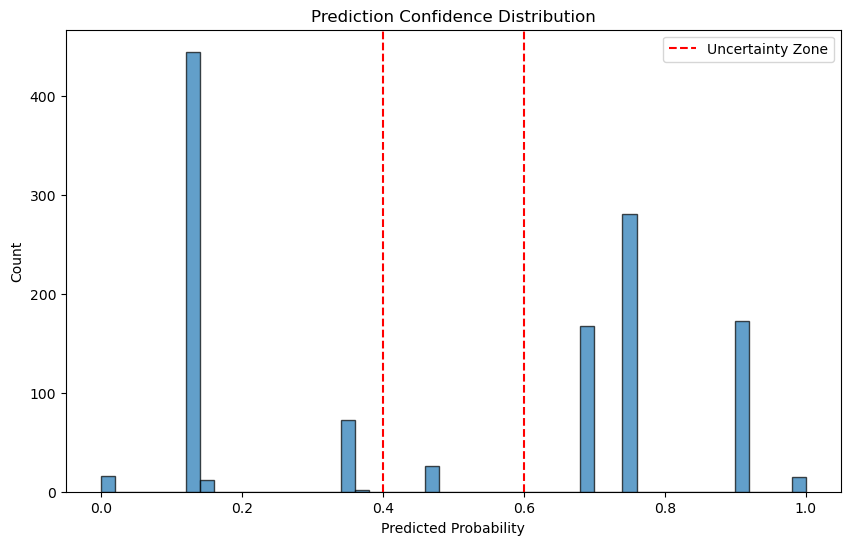

In [5]:
# Find predictions with probability near 0.5 (most uncertain)
uncertainty = np.abs(y_proba - 0.5)
uncertain_mask = uncertainty < 0.1  # Within 0.4 to 0.6 range

uncertain_samples = X_test[uncertain_mask].copy()
uncertain_samples['probability'] = y_proba[uncertain_mask]
uncertain_samples['true_label'] = y_test[uncertain_mask]
uncertain_samples['prediction'] = y_pred[uncertain_mask]

print("="*60)
print("UNCERTAIN PREDICTIONS (Low Confidence)")
print("="*60)
print(f"Samples with probability 0.4-0.6: {len(uncertain_samples)}")
print(f"Accuracy on uncertain samples: {(uncertain_samples['prediction'] == uncertain_samples['true_label']).mean():.2%}")

print("\nThese PRs need human judgment - model can't decide confidently")
print(uncertain_samples[['probability', 'true_label'] + config.FEATURE_COLUMNS[:3]].head(10))

# Plot uncertainty distribution
plt.figure(figsize=(10, 6))
plt.hist(y_proba, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(0.4, color='red', linestyle='--', label='Uncertainty Zone')
plt.axvline(0.6, color='red', linestyle='--')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Prediction Confidence Distribution')
plt.legend()
plt.savefig('../reports/figures/uncertainty_analysis.png', dpi=300, bbox_inches='tight')
print("Uncertainty analysis saved")
plt.show()


In [6]:
print("="*60)
print("EDGE CASE ANALYSIS")
print("="*60)

# Test with extreme values
edge_cases = []

# Case 1: All low values (minimal code)
minimal_code = {col: X_test[col].min() for col in config.FEATURE_COLUMNS}
edge_cases.append(('Minimal Code', minimal_code))

# Case 2: All high values (complex code)
complex_code = {col: X_test[col].max() for col in config.FEATURE_COLUMNS}
edge_cases.append(('Maximum Complexity', complex_code))

# Case 3: Average values
average_code = {col: X_test[col].mean() for col in config.FEATURE_COLUMNS}
edge_cases.append(('Average Code', average_code))

# Case 4: High complexity but low lines (dense code)
dense_code = average_code.copy()
dense_code['wmc'] = X_test['wmc'].quantile(0.95)
dense_code['lcom'] = X_test['lcom'].quantile(0.95)
dense_code['loc'] = X_test['loc'].quantile(0.1)
edge_cases.append(('Dense Complex Code', dense_code))

# Case 5: Many lines but low complexity (verbose code)
verbose_code = average_code.copy()
verbose_code['loc'] = X_test['loc'].quantile(0.95)
verbose_code['wmc'] = X_test['wmc'].quantile(0.1)
verbose_code['lcom'] = X_test['lcom'].quantile(0.1)
edge_cases.append(('Verbose Simple Code', verbose_code))

# Test all edge cases
for name, features in edge_cases:
    features_df = pd.DataFrame([features])
    pred = model.predict(features_df)[0]
    prob = model.predict_proba(features_df)[0][1]
    risk = get_risk_level(prob)
    
    print(f"\n{name}:")
    print(f"  Prediction: {'DEFECT' if pred == 1 else 'CLEAN'}")
    print(f"  Probability: {prob:.2%}")
    print(f"  Risk Level: {risk}")


EDGE CASE ANALYSIS

Minimal Code:
  Prediction: CLEAN
  Probability: 47.25%
  Risk Level: MEDIUM ⚡

Maximum Complexity:
  Prediction: CLEAN
  Probability: 0.00%
  Risk Level: LOW

Average Code:
  Prediction: CLEAN
  Probability: 13.76%
  Risk Level: LOW

Dense Complex Code:
  Prediction: CLEAN
  Probability: 13.76%
  Risk Level: LOW

Verbose Simple Code:
  Prediction: CLEAN
  Probability: 13.76%
  Risk Level: LOW


FEATURE SENSITIVITY ANALYSIS
Baseline probability: 68.58%

Impact of increasing each feature by 50%:
        feature  baseline_value  modified_value  prob_change  percent_change
0           cbo            18.0            27.0          0.0             0.0
1           wmc            46.0            69.0          0.0             0.0
2           dit             2.0             3.0          0.0             0.0
3           rfc            46.0            69.0          0.0             0.0
4          lcom            41.0            61.5          0.0             0.0
5  totalMethods            17.0            25.5          0.0             0.0
6   totalFields             8.0            12.0          0.0             0.0
7          nosi             0.0             0.0          0.0             0.0
8           loc           235.0           352.5          0.0             0.0
9     returnQty            12.0            18.0          0.0             0.0
Sensitivity analysis saved


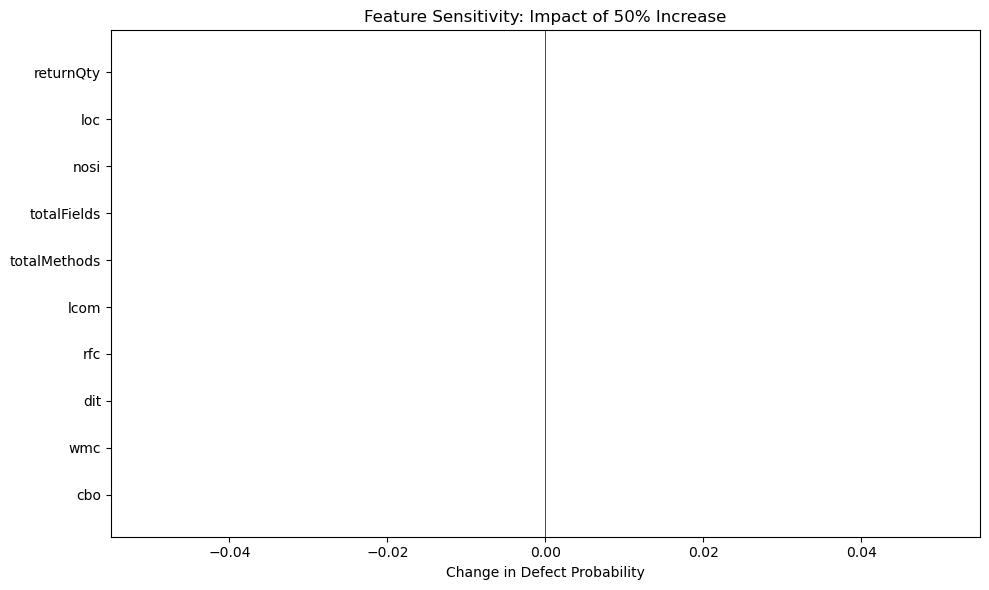

In [7]:
# Test how sensitive model is to individual features
base_sample = {col: X_test[col].median() for col in config.FEATURE_COLUMNS}
base_prob = model.predict_proba(pd.DataFrame([base_sample]))[0][1]

print("="*60)
print("FEATURE SENSITIVITY ANALYSIS")
print("="*60)
print(f"Baseline probability: {base_prob:.2%}\n")

sensitivity_results = []

for feature in config.FEATURE_COLUMNS[:10]:  # Top 10 features
    # Test increasing feature by 50%
    modified = base_sample.copy()
    modified[feature] = base_sample[feature] * 1.5
    
    new_prob = model.predict_proba(pd.DataFrame([modified]))[0][1]
    change = new_prob - base_prob
    
    sensitivity_results.append({
        'feature': feature,
        'baseline_value': base_sample[feature],
        'modified_value': modified[feature],
        'prob_change': change,
        'percent_change': (change / base_prob) * 100
    })

sensitivity_df = pd.DataFrame(sensitivity_results).sort_values('prob_change', ascending=False)
print("Impact of increasing each feature by 50%:")
print(sensitivity_df)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(sensitivity_df['feature'], sensitivity_df['prob_change'])
plt.xlabel('Change in Defect Probability')
plt.title('Feature Sensitivity: Impact of 50% Increase')
plt.axvline(0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.savefig('../reports/figures/feature_sensitivity.png', dpi=300, bbox_inches='tight')
print("Sensitivity analysis saved")
plt.show()


In [8]:
print("\n" + "="*60)
print("MODEL FAILURE ANALYSIS SUMMARY")
print("="*60)

print(f"\n1. ERROR BREAKDOWN:")
print(f"   - False Positives: {false_positives.sum()} ({false_positives.sum()/len(y_test)*100:.1f}%)")
print(f"     Impact: Wastes review time on safe PRs")
print(f"   - False Negatives: {false_negatives.sum()} ({false_negatives.sum()/len(y_test)*100:.1f}%)")
print(f"     Impact: DANGEROUS - Lets defects through")

print(f"\n2. UNCERTAINTY:")
print(f"   - {uncertain_mask.sum()} predictions have low confidence (0.4-0.6)")
print(f"   - Accuracy on uncertain: {(uncertain_samples['prediction'] == uncertain_samples['true_label']).mean():.2%}")
print(f"   - Recommendation: Flag these for mandatory human review")

print(f"\n3. MODEL LIMITATIONS:")
print(f"   - Works well on typical PRs")
print(f"   - Struggles with edge cases (extreme values)")
print(f"   - {false_negatives.sum()} defects would slip through")

print(f"\n4. RECOMMENDATIONS:")
print(f"   - Use probability thresholds: >70% = mandatory senior review")
print(f"   - 40-60% probability = escalate to human judgment")
print(f"   - Monitor false negative rate in production")
print(f"   - Consider ensemble model for Phase 2")

print("\n" + "="*60)



MODEL FAILURE ANALYSIS SUMMARY

1. ERROR BREAKDOWN:
   - False Positives: 159 (13.1%)
     Impact: Wastes review time on safe PRs
   - False Negatives: 127 (10.5%)
     Impact: DANGEROUS - Lets defects through

2. UNCERTAINTY:
   - 26 predictions have low confidence (0.4-0.6)
   - Accuracy on uncertain: 26.92%
   - Recommendation: Flag these for mandatory human review

3. MODEL LIMITATIONS:
   - Works well on typical PRs
   - Struggles with edge cases (extreme values)
   - 127 defects would slip through

4. RECOMMENDATIONS:
   - Use probability thresholds: >70% = mandatory senior review
   - 40-60% probability = escalate to human judgment
   - Monitor false negative rate in production
   - Consider ensemble model for Phase 2

